In [35]:
import json
import pandas as pd

# Load the data from the JSON file
with open('sentiment_data.json') as f:
    data = json.load(f)

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Apply the dictionary under 'sentiment scores' to create new columns
df[['neg', 'neu', 'pos', 'compound']] = df['sentiment_scores'].apply(pd.Series)

# Drop the 'sentiment scores' column
df.drop('sentiment_scores', axis=1, inplace=True)

# Print the DataFrame
df.head()


,stars,review_id,sentiment_class,neg,neu,pos,compound
0,3.0,ZKvDG2sBvHVdF5oBNUOpAQ,negative,0.199,0.680,0.122,-0.8995
1,3.0,pUycOfUwM8vqX7KjRRhUEA,positive,0.015,0.752,0.233,0.9782
2,4.0,eCiWBf1CJ0Zdv1uVarEhhw,positive,0.000,0.746,0.254,0.9622
3,5.0,YbMyvlDA2W3Py5lTz8VK-A,positive,0.000,0.768,0.232,0.8655
4,5.0,L0jv8c2FbpWSlfNC6bbUEA,positive,0.000,0.719,0.281,0.9168


1.0     42785
2.0     23318
3.0     28859
4.0     63367
5.0    189864
Name: stars, dtype: int64

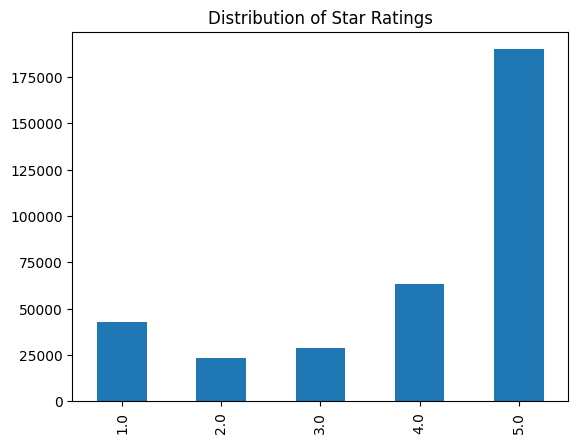

In [36]:
# plot the distribution of the star ratings, which are a categorica variable
df['stars'].value_counts().sort_index().plot(kind='bar', title='Distribution of Star Ratings')

# print the number of reviews for each star rating
df['stars'].value_counts().sort_index()

In [39]:
# calculate spearmans rank correlation coefficient
df.corr(method='spearman')


/var/folders/d8/zh6815pd1j53q8hpl5px6f6r0000gn/T/ipykernel_56228/177221135.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='spearman')


,stars,neg,neu,pos,compound
stars,1.000000,-0.499667,-0.376964,0.575483,0.480396
neg,-0.499667,1.000000,0.170245,-0.549792,-0.437022
neu,-0.376964,0.170245,1.000000,-0.875042,-0.373751
pos,0.575483,-0.549792,-0.875042,1.000000,0.587585
compound,0.480396,-0.437022,-0.373751,0.587585,1.000000


In [40]:
import pandas as pd
from sklearn.utils import resample

# Load your DataFrame 'df' here

# Calculate the number of samples you want to keep for the more frequent classes.
# For example, if you want to keep the same number of samples as class 2 (least frequent):
n_samples = df['stars'].value_counts()[2.0]

# Perform undersampling
df_1 = resample(df[df['stars'] == 1.0], replace=False, n_samples=n_samples, random_state=42)
df_2 = df[df['stars'] == 2.0]
df_3 = df[df['stars'] == 3.0]
df_4 = resample(df[df['stars'] == 4.0], replace=False, n_samples=n_samples, random_state=42)
df_5 = resample(df[df['stars'] == 5.0], replace=False, n_samples=n_samples, random_state=42)

# Combine the resampled subsets and shuffle the resulting DataFrame
df_resampled = pd.concat([df_1, df_2, df_3, df_4, df_5])
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)


In [41]:
# Multinomial logistic regression in statsmodels
import statsmodels.api as sm
import statsmodels.miscmodels.ordinal_model as om

# Fit the ordered model to regress positive and negative sentiment against the star rating
model = om.OrderedModel(df_resampled['stars'], df_resampled[['neg', 'pos']])
result = model.fit(maxiter=10000)
result.summary()

Optimization terminated successfully.
         Current function value: 1.310046
         Iterations: 648
         Function evaluations: 993


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  stars   Log-Likelihood:            -1.6000e+05
Model:                   OrderedModel   AIC:                         3.200e+05
Method:            Maximum Likelihood   BIC:                         3.201e+05
Date:                Sat, 25 Mar 2023                                         
Time:                        11:10:49                                         
No. Observations:              122131                                         
Df Residuals:                  122125                                         
Df Model:                           6                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
neg           -7.2596      0.062   -117.308      0.000      -7.381      -7.138
pos            6.1243      0.035    174.264      0.000       6.055       6.193
1.0/2.0       -0.6392      0.009    -71.375      0.000      -0.657      -0.622
2.0/3.0       -0.2124      0.006    -36.426      0.000      -0.224      -0.201
3.0/4.0       -0.1168      0.005    -22.348      0.000      -0.127      -0.107
4.0/5.0       -0.2148      0.006    -36.757      0.000      -0.226      -0.203
==============================================================================
"""

In [42]:
result.predict(df[['neg', 'pos']].loc[0])

,0,1,2,3,4
None,0.523235,0.283781,0.153502,0.0343,0.005182


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the class labels
y_pred = result.predict().argmax(axis=1) + 1

# Calculate accuracy
accuracy = accuracy_score(df_resampled['stars'], y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision, recall, and F1 score for each class (star rating)
precision = precision_score(df_resampled['stars'], y_pred, average=None, zero_division=0)
recall = recall_score(df_resampled['stars'], y_pred, average=None)
f1 = f1_score(df_resampled['stars'], y_pred, average=None)

# Print the results
for i, (p, r, f) in enumerate(zip(precision, recall, f1), start=1):
    print(f"Star rating {i}: Precision = {p:.3f}, Recall = {r:.3f}, F1 score = {f:.3f}")

weighted_f1 = f1_score(df_resampled['stars'], y_pred, average='weighted')
print(f"Weighted F1 score: {weighted_f1}")

Accuracy: 0.4093391522217946
Star rating 1: Precision = 0.532, Recall = 0.581, F1 score = 0.555
Star rating 2: Precision = 0.341, Recall = 0.155, F1 score = 0.214
Star rating 3: Precision = 0.331, Recall = 0.602, F1 score = 0.427
Star rating 4: Precision = 0.350, Recall = 0.121, F1 score = 0.180
Star rating 5: Precision = 0.495, Recall = 0.541, F1 score = 0.517
Weighted F1 score: 0.3808880264272912
